In [1]:
import re
import urllib.request
from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import datetime
import seaborn as sns

# page nos. 1 to 1539
persian_steingass_url = 'https://dsal.uchicago.edu/cgi-bin/app/steingass_query.py?page={}'

In [2]:
def processDefChild(child):
    if child.name:
        return '<{0}>{1}</{0}>'.format(child.name, child.text.strip())
    else:
        return child.text.strip()
    
def unmatchedParen(s):
    if s is None:
        return ''
    stack = []
    for c in s:
        if c == '(':
            stack.append(c)
        elif c == ')':
            if len(stack) == 0:
                return ')'
            stack.pop()
    if len(stack) > 0:
        return '('
    else:
        return ''


def processEntry(hw):
    result = {
        'definition': ' '.join(processDefChild(sib)
                for sib in hw.next_siblings),
        'pa': hw.pa.string,
        'ro': hw.i.string if hw.i else '',
        'lang': hw.parent.lang.string if hw.parent.lang else '',
        'page': page,
        'comment': '',
        # the following are only used for intermediate processing
        'hw_raw': hw.text
    }
    
    if unmatchedParen(result['ro']) == '(':
        result['ro'] = result['ro'][:result['ro'].index('(')].strip()

        if ')' in result['hw_raw']:
            result['comment'] = result['hw_raw'][result['hw_raw'].index('('):
                                                 result['hw_raw'].index(')') + 1]
        elif ')' in result['definition']:
            result['comment'] = (result['hw_raw'][result['hw_raw'].index('('):] + 
                                result['definition'][:result['definition'].index(')') + 1]).strip()
            result['definition'] = result['definition'][result['definition'].index(')') + 1:].strip()
    elif unmatchedParen(result['ro']) == ')':
        result['ro'] = result['ro'][result['ro'].index(')') + 1:].strip()
        result['comment'] = (result['hw_raw'][result['hw_raw'].index('('):]).strip()
    
    result['definition'] = re.sub(r'^\s*,', '', result['definition']).strip()
    
    del result['hw_raw']
    
    return result

def getSteingassPage(page):
    with urllib.request.urlopen(persian_steingass_url.format(page)) as response:
        html = response.read()
        html = html.decode('utf-8')
    bs = BeautifulSoup(html)
    df = DataFrame([processEntry(hw) for hw in bs.find_all('hw')])
    if len(df) == 0:
        return df
    else:
        return df[['pa', 'ro', 'definition', 'lang', 'page', 'comment']]

In [37]:
DON'T RERUN

pages = []

for page in range(1, 1540):
    print('=', end='')
    if page % 5 == 0:
        print('|', end='')
        if page % 50 == 0:
            print(page, datetime.datetime.now())
    pages.append(getSteingassPage(page))

FullDict = pd.concat(pages)

FullDict.to_csv('steingass.csv')

=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|50 2022-02-03 10:13:24.469091
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|100 2022-02-03 10:13:47.960755
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|150 2022-02-03 10:14:11.434427
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|200 2022-02-03 10:14:35.085562
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|250 2022-02-03 10:15:00.048992
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|300 2022-02-03 10:15:23.218841
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|350 2022-02-03 10:15:46.892086
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|400 2022-02-03 10:16:13.071702
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|450 2022-02-03 10:16:36.728211
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|500 2022-02-03 10:17:00.093801
=====|=====|=====|=====|=====|=====|=====|=====|=====|=====|550 2022-02-03 10:17:24.423350


In [46]:
#FullDict.to_csv('steingass.csv')

In [15]:
FullDict = pd.read_csv('steingass.csv', keep_default_na=False)
SUBDEF_CHAR = '—'

FullDict['def_len'] = FullDict.definition.str.len()
FullDict['subdef_count'] = FullDict.definition.fillna('').apply(lambda d: len(d.split(SUBDEF_CHAR)))

<AxesSubplot:>

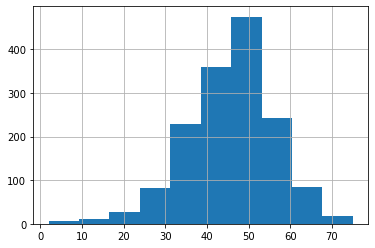

In [16]:
#Entries per page
FullDict.page.value_counts().hist()

In [5]:
# missing pages are all due to continuations of long entries, grouped withfollowing pages
# 2
# 41
# 486
# 520
# 665
# 666
for p in range(1, 1540):
    if not p in list(FullDict.page):
        print(p)

2
41
486
520
665
666


In [6]:
# Length of definitions varies a lot

FullDict.definition.str.len().describe()

count    69887.000000
mean        84.007197
std        206.624001
min          2.000000
25%         22.000000
50%         41.000000
75%         86.000000
max      19426.000000
Name: definition, dtype: float64

In [17]:
# top words by definition length

'; '.join(list(FullDict.sort_values('def_len', ascending=False)[:150].ro))

'sar; dast; āb; ḵẖẉush, ḵẖẉash; az; sang; ḵẖat̤t̤; ahl; gil; kār; yāʼ, yā; chashm; ʻalm; dandān; ḥarf; ṣāḥib; g̠ẖair; rāh; ātish; ḵẖūd; īn; ḵẖūn; rawī; marg̠ẖ; dil; zabān, zubān; gosh; faʻl; ḥaqq, ḥaq; nān; kashīdan; tīr; bād; zar; parda; rang; ʻalá; h; roz; dāman; suḵẖun, suḵẖan, saḵẖan, saḵẖun; dam; ḵẖāna; pusht; gard; jāma; kulāh; teg̠ẖ; dar; ḵẖāk; daryā; ʻain; bāz; pāy; angusht; ʻarẓ; jān; ḵẖẉāb; sher; qalb; naqsh; giriftan; taḵẖt; nafs; ʻanān; shāḵẖ; lab; shab; dāg̠ẖ; pas; taḵẖta; zīr, zer; qat̤ʻ; y; band; chashma; ʻālam; kāsa; dār; qadm; ḵẖam; chūb, chob; gara; pesh; kamar; āyina; husn; rishta; jamʻ; ism; chirāg̠ẖ; kāmān; māh; jām; tuḵẖm; naql; naz̤r; ganj; charḵẖ; diraḵẖt; panja; pīr; mail; t̤arf; nāma; ʻarq; bār; ḵẖār; qabl; kāg̠ẖaẕ, kāg̠ẖiẕ; ḥurūf; māl; sharāb; naʻl; dard; nāḵẖun; dīda; qaẓā; nām; shamsher; kashtī; ḥukm; kala; zamīn; bar sar; kardan; w; cha; raish; m; man; ban; raug̠ẖan; gāu, gāo, gāv; baḥr; qūwat, quwwat; qafl; par, parr; ḥalqat, ḥalqa; abū; nishān; ashk; war

In [18]:
# top words by subdefinition count
# the one with missing romanization is mīr

'; '.join(list(FullDict.sort_values('subdef_count', ascending=False)[:150].ro.fillna('!!!')))

'sar; dast; āb; ḵẖẉush, ḵẖẉash; ahl; az; sang; gil; ḵẖat̤t̤; ʻalm; ṣāḥib; g̠ẖair; ḥarf; rāh; kār; dandān; chashm; ḵẖūd; ātish; īn; ḵẖūn; rawī; dil; marg̠ẖ; zar; zabān, zubān; kashīdan; nān; ʻalá; ḥaqq, ḥaq; bād; parda; gosh; ḵẖāna; suḵẖun, suḵẖan, saḵẖan, saḵẖun; faʻl; roz; dam; rang; dāman; sher; pusht; daryā; dār; tīr; ḵẖẉāb; ḵẖāk; pas; ism; diraḵẖt; jāma; pāy; teg̠ẖ; shab; giriftan; gard; zīr, zer; lab; angusht; ʻālam; jān; ʻanān; kāsa; chūb, chob; husn; dar; taḵẖta; ḥurūf; chashma; pesh; dard; naqsh; kāmān; kulāh; raug̠ẖan; tuḵẖm; māh; chirāg̠ẖ; qadm; shāḵẖ; kardan; bāz; qūwat, quwwat; gara; māl; bilā (bi-lā); dīda; qat̤ʻ; āyina; taḵẖt; sharāb; nafs; kashtī; shamʻ; pīr; zamīn; abū; ḵẖār; rishta; dāg̠ẖ; jauhar; baḥr; waqt; cha; zadan; har; jām; ḵẖam; āstīn; jāy; arbāb; ; bāg̠ẖ; ḥamá; ʻain; nām; jamʻ; ʻarq; ganj; gāu, gāo, gāv; ḥukm; ʻuẓlat; panja; ḥalqat, ḥalqa; kamar; rag; nāḵẖun; ashk; bar sar; ʻand, ʻind, ʻund; qalm; chādar; ban; charḵẖ; mā; koh, kūh; nihādan; man; ẕī; tā; burj; 

In [19]:
subdefs = []

for _, row in FullDict[FullDict['subdef_count'] > 1].iterrows():
    for subdef in row.definition.split(SUBDEF_CHAR)[1:]:
        subdefs.append({
            'hw_ro': row['ro'],
            'subdef': subdef,
            'page': row['page'],
            'subdef_len': len(subdef)
        })

#DataFrame(subdefs).sample(50)

DataFrame(subdefs).sort_values('subdef_len', ascending=False)[:50]

,hw_ro,subdef,page,subdef_len
31538,"yāʼ, yā",i. <i>yāʼi (yāyi) istimrārī</i> (being <i>maj...,1524,5473
15428,sī laḥn,1. <i>ārāyishi ḵẖẉurshed (jahān)</i> ; 2. <i>...,717,953
29527,naz̤r,"<i>naz̤ar</i> (v.n.), Looking at, beholding, ...",1410,833
26729,maṣlīy,"<i>muṣallá</i> , Prayed; merciful, propitious...",1254,757
31280,"halāl, hilāl","<i>hilāl</i> (v.n. 3 of <pa>هلّ</pa> ), Agree...",1505,671
24722,m,am</i> (after a noun terminating in a vowel f...,1136,631
18172,ʻarf,"<i>ʻurf</i> , Being known, public, notorious;...",844,611
23027,kanda,"<i>kunda</i> , The stocks for offenders, a ki...",1054,610
21473,qamʻ,"<i>qamaʻ</i> (v.n.), Suffering from a fistula...",989,524
28696,mail,"<i>mīl</i> , A mile of four thousand cubits o...",1363,522


In [21]:
FullDict[~FullDict.ro.apply(bool)].sort_values('def_len', ascending=False)

,Unnamed: 0,pa,ro,definition,lang,page,comment,def_len,subdef_count
62009,23,مير,,"(for A. <pa>امير</pa> ), An emperor, prince, l...",a,1360,,1414,23
39207,8,ع ʻ,,called <i>ʻaini g̠ẖair manqūt̤a</i> or <i>ʻain...,,828,,824,1
37267,46,ص,,The seventeenth letter of the Arabic-Persian a...,,777,,635,1
30662,54,س,,"called <i>sīni g̠ẖair manqūt̤a, sīni muhmala</...",,637,,307,1
68463,21,همز,,"(v.n.), Squeezing (in the hand); making a sign...",A,1510,,283,2
15676,14,تععيل,,"Causing to be unemployed; rendering vacant, vo...",A,309,,253,2
1007,26,اختلال,,"Being lean, emaciated; standing in need; sewin...",A,24,,232,3
5387,19,انشاز,,Raising (anything) from its place; collecting ...,A,111,,154,1
49127,6,گاو نبطونك,,"(?), (in the dialect of Shīrāz) A kind of spur...",,1074,,137,1
62649,27,ناشبسته,,"(?), Unwashed (the word given by Meninsky is e...",,1373,,101,1


In [23]:
FullDict[~FullDict.definition.apply(bool)]

,Unnamed: 0,pa,ro,definition,lang,page,comment,def_len,subdef_count
478,8,آتش آلود,ātish-ālūd,,,13,,0,1


In [24]:
for _, row in FullDict[FullDict.definition.apply(unmatchedParen).apply(bool)].iterrows():
    print('==={}, page {}==='.format(row.ro, row.page))
    print(row.definition)

===iḵẖtifāʼ, page 24===
Hiding, covering, concealment).
===āḵẖsuma, āḵẖsama, aḵẖsuma, aḵẖsamah, page 25===
), A liquor made from barley, rice, or millet.
===azrār, page 44===
(pl. of <i>zirr</i> ), Buttons; — <i>izrār</i> (v.n. 4 of <pa>زرّ</pa> ), Putting buttons to a garment).
===āsh, page 62===
(S. <i>āśa</i> ), Meat, victuals, viands, soup, broth, gruel, pottage; drinking, a drinker; — <i>āshi bādardī</i> , A dish called after Bādard, a place in Khurasān; — <i>āshi bachagān</i> , Castor (a medicine given to infants); — <i>āsh puḵẖtan</i> , To stir up one against another; — <i>āshi tatmāj</i> , A kind of vermicelli dish; — <i>āshi tazwīr (parhez)</i> , Gruel for the sick; — <i>āshi taʻziya</i> , A dish distributed to the neighbours and poor on a day of mourning (as on that for the death of Husain); — <i>āshi tū dar kāsaʼi tūst</i> , Your food is in your bowl, <i>i.e.</i> your living or lot is provided for; — <i>āshi jav</i> , Barley-water, water-gruel; — <i>āshi ḵẖalīli (ḵẖalīli ʼll

In [25]:
FullDict[FullDict.ro.apply(unmatchedParen).apply(bool)]

,Unnamed: 0,pa,ro,definition,lang,page,comment,def_len,subdef_count


In [26]:
FullDict[FullDict.definition.apply(unmatchedParen).apply(bool)]

,Unnamed: 0,pa,ro,definition,lang,page,comment,def_len,subdef_count
999,18,اختفاء,iḵẖtifāʼ,"Hiding, covering, concealment).",A,24,,31,1
1057,30,اخسمه,"āḵẖsuma, āḵẖsama, aḵẖsuma, aḵẖsamah","), A liquor made from barley, rice, or millet.",,25,,46,1
1977,0,ازرار,azrār,"(pl. of <i>zirr</i> ), Buttons; — <i>izrār</i>...",A,44,,104,2
2913,12,آش,āsh,"(S. <i>āśa</i> ), Meat, victuals, viands, soup...",,62,,1328,19
3407,17,اظ‍ﮩ‍ار,iz̤ḥār,"Revealing, discovering; manifestation, disclos...",A,72,,513,5
...,...,...,...,...,...,...,...,...,...
64626,43,نگين,nigīn,"A ring, especially the seal-ring of a prince; ...",,1424,,422,6
66814,31,وعدة,"waʻdat, waʻda","A promise, vow; any determined, appointed, cer...",A,1473,,506,4
66856,36,وغف,wag̠ẖf,"(v.n.), Walking fast, running; weakness in the...",A,1474,,151,1
67206,50,ويشه,wesha,"A forest, wood (cf. <pa>بيشه</pa> p. 221; — <i...",,1483,,63,2


In [29]:
FullDict.ro.value_counts()

              56
farīs          3
bīr            3
anīs           3
bar            3
              ..
ḵẖunuk         1
ḵẖunukā        1
ḵẖunkār        1
ḵẖunuk-jān     1
yayan          1
Name: ro, Length: 69275, dtype: int64

<AxesSubplot:ylabel='lang'>

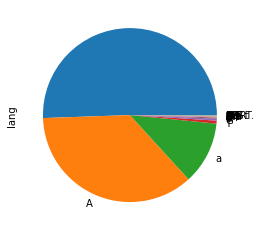

In [32]:
FullDict.lang.value_counts().plot.pie()

In [35]:
for c in 'asdsdasd':
    print(c)

a
s
d
s
d
a
s
d


In [42]:
# NOT DONE
def hasDashInParens(s):
    inParens = False
    
    for i in len(s):
        c = s[i]
        if c == '(':
            pass
    return False

def hasNestedParens(s):
    inParens = False
    
    for c in s:
        if c == '(':
            if inParens:
                return True
            else:
                inParens = True
        if c == ')':
            inParens = False
    return False

# i.e. — not preceded by ;
def hasLooseDash(s):
    for i in range(len(s)):
        if s[i] == '—':
            if i < 2 or s[i-2] != ';':
                return True
    return False

FullDict[FullDict.definition.apply(hasLooseDash)]

,Unnamed: 0,pa,ro,definition,lang,page,comment,def_len,subdef_count
363,5,ابواب,abwāb,"(pl. of <i>bāb</i> ), Gates, doors; chapters, ...",A,11,,348,4
945,11,اخ,āḵẖ,"Vestige; sign; — <i>aḵẖ</i> , Ah! bravo! coura...",,23,,141,3
947,13,اخ,aḵẖḵẖ,Fye! ah! alas! — <i>aḵẖḵẖ</i> or <i>iḵẖḵẖ</i> ...,A,23,,60,2
949,15,اخ اخ,aḵẖ aḵẖ,"Good! good! ah! alas! — <i>uḵẖ uḵẖ</i> , Excel...",,23,,51,2
1167,32,ادارات,idārāt,"(pl. of the preceding), Turns, &c. — <i>idārāt...",A,27,,98,2
...,...,...,...,...,...,...,...,...,...
69445,59,يسار,yasār,"Plenty, affluence, opulence; ease; — <i>yasār,...",A,1530,,277,5
69550,51,يك,yak,"One, everyone; once; an ace; custom, habit; la...",,1532,,292,2
69674,4,يکی,yake,"One, somebody, a certain one; the one; [ <i>ya...",,1535,,586,11
69772,10,یند,yand,"(for <i>and</i> ), Are, as: — <i>ḵẖadami o yan...",,1537,,78,2


In [45]:
FullDict.iloc[363].definition

'(pl. of <i>bāb</i> ), Gates, doors; chapters, sections; conjugations; points, principles; dues, fees, heads or subjects of taxation; — <i>abwābi thānadārī</i> , Taxes on retailers of liquors, &c. — <i>abwābi shādī</i> , An imposition levied to defray the marriage expenses of a great personage; — <i>ba hamah abwāb</i> , By all means, in every way.'

In [39]:
getSteingassPage(267)

NameError: name 'page' is not defined

In [50]:
with urllib.request.urlopen(persian_steingass_url.format(11)) as response:
    html = response.read()
    html = html.decode('utf-8')
    bs = BeautifulSoup(html)

In [51]:
def processEntry(hw):
    result = {
        'definition': ' '.join(processDefChild(sib)
                for sib in hw.next_siblings),
        'pa': hw.pa.string,
        'ro': hw.i.string if hw.i else '',
        'lang': hw.parent.lang.string if hw.parent.lang else '',
        #'page': page,
        'comment': '',
        # the following are only used for intermediate processing
        'hw_raw': hw.text
    }
    
    if unmatchedParen(result['ro']) == '(':
        result['ro'] = result['ro'][:result['ro'].index('(')].strip()

        if ')' in result['hw_raw']:
            result['comment'] = result['hw_raw'][result['hw_raw'].index('('):
                                                 result['hw_raw'].index(')') + 1]
        elif ')' in result['definition']:
            result['comment'] = (result['hw_raw'][result['hw_raw'].index('('):] + 
                                result['definition'][:result['definition'].index(')') + 1]).strip()
            result['definition'] = result['definition'][result['definition'].index(')') + 1:].strip()
    elif unmatchedParen(result['ro']) == ')':
        result['ro'] = result['ro'][result['ro'].index(')') + 1:].strip()
        result['comment'] = (result['hw_raw'][result['hw_raw'].index('('):]).strip()
    
    result['definition'] = re.sub(r'^\s*,', '', result['definition']).strip()
    
    del result['hw_raw']
    
    return result

(lambda x: [i for i in x if '—' in i['definition']])([processEntry(hw) for hw in bs.find_all('hw')])

[{'definition': 'Made of ebony; — <i>ābnūsī-shāḵẖ</i> , An ebony pipe; a pipe played on any festivity.',
  'pa': 'آبنوسى',
  'ro': 'ābnūsī',
  'lang': '',
  'comment': ''},
 {'definition': "A father; — <i>abū ʼl-arwāḥ</i> , Quicksilver; — <i>abū ʼl bashar</i> , Adam, the father of man; — <i>abū ʼl-jamʻ</i> , Chieftain; — <i>abū ʼl-ḥuṣain</i> , Father of the little fortress, <i>i.e.</i> a fox; — <i>abū ʼl-hayā</i> , Name of Othmān, the third Khalīf; — <i>abū ʼl-hayya (-ʻabbās, mit̤rāq)</i> , Penis; — <i>abū ʼl-faẓl</i> , Name of the accomplished secretary to Sultān Akbar, and author of the <i>Akbar-nāmah; — abū ʼl-kunjak</i> , Anything new, rare, or agreeable; a facetious, witty, or well-bred man; a buffoon, jester, mimic; — <i>abū barāqish</i> , Name of a speckled bird; — <i>abū bakr</i> , The father-in-law and first Khalīf, or successor to Muhammad; — <i>abū turāb</i> , Name of Ali, son-in-law to Muhammad; — <i>abū jahl</i> , Name of an uncle of Muhammad; — <i>abū ḥāris̤</i> , A lion;